In [2]:
%load_ext autoreload
%autoreload 2
import sys
import os
import joblib
from typing import Any
sys.path.insert(0, os.path.abspath('..'))

from src.feature_engineer import load_encoder
from src.utils.model_utils import evaulate_model, train_model
from src.utils.visualize_utils import plot_cm, get_avg_fold
from src.utils.math_utils import get_fft_power

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

from scipy.spatial.transform import Rotation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
raw_path = "../data/raw"
encoder_path = "../models/label_encoder.pkl"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# preprocess
full_df = pd.merge(
    left=pd.read_csv(os.path.join(raw_path, "train.csv")),
    right=pd.read_csv(os.path.join(raw_path, "train_demographics.csv")),
    on="subject",
    how="left",
)

full_df = full_df.drop(columns=[col for col in full_df.columns if col.startswith("tof_")])

full_df

In [ ]:
non_target_gestures = full_df[full_df["sequence_type"] == "Non-Target"]["gesture"].unique()
target_gestures = full_df[full_df["sequence_type"] == "Target"]["gesture"].unique()

filtered_df = full_df[full_df["phase"] == "Gesture"]
filtered_df.loc[filtered_df["sequence_type"] == "Non-Target", "gesture"] = non_target_gestures[0]

# drop the fucken kids
filtered_df = filtered_df[filtered_df['adult_child'] == 0]
# feature engineer rot_w r_x, rt_y rotz
# drop na
bad_seq_id = full_df[full_df["rot_w"].isnull()]["sequence_id"].unique()
bad_seq_mask = filtered_df["sequence_id"].isin(bad_seq_id)
filtered_df = filtered_df[~bad_seq_mask]
filtered_df["rot_w"].isnull().sum()


# rotation vector crafting
quat = filtered_df[["rot_w", "rot_x", "rot_y", "rot_z"]]
rotation_object = Rotation.from_quat(quat)
rotation_vectors = rotation_object.as_rotvec()

filtered_df["rotvec_x"] = rotation_vectors[:, 0]
filtered_df["rotvec_y"] = rotation_vectors[:, 1]
filtered_df["rotvec_z"] = rotation_vectors[:, 2]
filtered_df["rot_angle"] = np.linalg.norm(rotation_vectors, axis=1)

filtered_df["rotvec_x_diff"] = filtered_df.groupby("sequence_id")["rotvec_x"].transform(lambda x: x.diff().fillna(0))
filtered_df["rotvec_y_diff"] = filtered_df.groupby("sequence_id")["rotvec_y"].transform(lambda x: x.diff().fillna(0))
filtered_df["rotvec_z_diff"] = filtered_df.groupby("sequence_id")["rotvec_z"].transform(lambda x: x.diff().fillna(0))
filtered_df["angular_mag"] = np.linalg.norm([filtered_df["rotvec_x_diff"], filtered_df["rotvec_y_diff"], filtered_df["rotvec_z_diff"]], axis=0)

# Feature Engineer for Accelerometer
cols_of_interest = ["acc_x", "acc_y", "acc_z"]

for col in cols_of_interest:
    filtered_df[f"fft_{col}"] = filtered_df.groupby("sequence_id")[col].transform(get_fft_power)

filtered_df["acc_mag"] = np.linalg.norm([filtered_df["acc_x"], filtered_df["acc_y"], filtered_df["acc_z"]], axis=0)
filtered_df["jerk_acc_x"] = filtered_df.groupby("sequence_id")["acc_x"].diff().fillna(0)
filtered_df["jerk_acc_y"] = filtered_df.groupby("sequence_id")["acc_y"].diff().fillna(0)
filtered_df["jerk_acc_z"] = filtered_df.groupby("sequence_id")["acc_z"].diff().fillna(0)

filtered_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,rotvec_y_diff,rotvec_z_diff,angular_mag,fft_acc_x,fft_acc_y,fft_acc_z,acc_mag,jerk_acc_x,jerk_acc_y,jerk_acc_z
25,SEQ_000007_000025,Target,SEQ_000007,25,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,0.000000,0.000000,0.000000,24206.0,16287.0,9289.0,9.924192,0.000000,0.000000,0.000000
26,SEQ_000007_000026,Target,SEQ_000007,26,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.984375,...,-0.009322,-0.028692,0.030410,37.0,65.0,209.0,10.113299,-0.042969,0.117188,0.343750
27,SEQ_000007_000027,Target,SEQ_000007,27,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,-0.002796,0.025619,0.041628,63.0,11.0,54.0,10.536305,0.042969,-0.152344,0.957031
28,SEQ_000007_000028,Target,SEQ_000007,28,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.488281,...,0.061592,0.046642,0.092412,9.0,0.0,52.0,9.782531,-0.539062,0.343750,-1.187500
29,SEQ_000007_000029,Target,SEQ_000007,29,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.988281,...,0.017812,0.006900,0.024087,0.0,0.0,2.0,9.925453,0.500000,0.191406,-0.765625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574839,SEQ_065522_000073,Target,SEQ_065522,73,SUBJ_040282,Lie on Back,Performs gesture,Gesture,Above ear - pull hair,-8.035156,...,-0.062710,-0.018604,0.071276,3.0,1.0,9.0,8.603203,0.496094,1.570312,-1.605469
574840,SEQ_065522_000074,Target,SEQ_065522,74,SUBJ_040282,Lie on Back,Performs gesture,Gesture,Above ear - pull hair,-9.257812,...,0.071417,-0.008840,0.091781,1.0,1.0,1.0,10.503829,-1.222656,-1.917969,-0.500000
574841,SEQ_065522_000075,Target,SEQ_065522,75,SUBJ_040282,Lie on Back,Performs gesture,Gesture,Above ear - pull hair,-9.035156,...,-0.055907,-0.046039,0.073372,0.0,1.0,28.0,9.547299,0.222656,2.031250,0.343750
574842,SEQ_065522_000076,Target,SEQ_065522,76,SUBJ_040282,Lie on Back,Performs gesture,Gesture,Above ear - pull hair,-8.531250,...,0.015253,0.023226,0.076780,1.0,5.0,15.0,9.950979,0.503906,-2.453125,0.191406


In [ ]:
agg_recipe = {
    "gesture": ["first"],
    "subject": ["first"],
    
    # ---Rotation
    "rotvec_x": ["mean", "std"],
    "rotvec_y": ["mean", "std"],
    "rotvec_z": ["mean", "std"],
    "rot_angle": ["mean", "std"],
    # angular velocity
    "rotvec_x_diff": ["mean", "std", "min", "max"],
    "rotvec_y_diff": ["mean", "std", "min", "max"],
    "rotvec_z_diff": ["mean", "std", "min", "max"],
    "angular_mag": ["mean", "std", "max"], # dont' add min here, it was always zero
    
    # ---Accelrometer
    "acc_x": ["mean", "std"],
    "acc_y": ["mean", "std"],
    "acc_z": ["mean", "std"],
    # mag
    "acc_mag": ["mean", "std"],
    # jerk
    "jerk_acc_x": ["mean", "std", "min", "max"],
    "jerk_acc_y": ["mean", "std", "min", "max"],
    "jerk_acc_z": ["mean", "std", "min", "max"],
    # fft stuff
    "fft_acc_x": ["mean", "std"],
    "fft_acc_y": ["mean", "std"],
    "fft_acc_z": ["mean", "std"],
}

filtered_df = filtered_df.groupby("sequence_id")[list(agg_recipe.keys())].agg(agg_recipe)  # type: ignore
filtered_df.columns = ["_".join(col).strip() if col[1] else col[0] for col in filtered_df.columns.values]
filtered_df = filtered_df.rename(
    columns={
        "gesture_first": "target",
        "subject_first": "subject",
    }
)

# encoder
target_df = filtered_df["target"]
subject_df = filtered_df["subject"]
encoder = load_encoder(encoder_path, target_df)

target_tensor = torch.tensor(encoder.transform(target_df), dtype=torch.long)
features_tensor = torch.tensor(filtered_df.drop(columns=["target", "subject"]).to_numpy(), dtype=torch.float32)
target_gestures_encoded = torch.tensor(encoder.transform(target_gestures))

filtered_df

,target,subject,rotvec_x_mean,rotvec_x_std,rotvec_y_mean,rotvec_y_std,rotvec_z_mean,rotvec_z_std,rot_angle_mean,rot_angle_std,...,jerk_acc_z_mean,jerk_acc_z_std,jerk_acc_z_min,jerk_acc_z_max,fft_acc_x_mean,fft_acc_x_std,fft_acc_y_mean,fft_acc_y_std,fft_acc_z_mean,fft_acc_z_std
sequence_id,,,,,,,,,,,,,,,,,,,,,
SEQ_000007,Cheek - pinch skin,SUBJ_059520,-0.491419,0.088411,0.646820,0.130625,0.920630,0.075947,1.237257,0.080723,...,-0.007202,0.849078,-2.644531,1.609375,765.343750,4277.463709,513.843750,2878.316781,313.968750,1638.559763
SEQ_000013,Cheek - pinch skin,SUBJ_040282,1.419351,0.117953,0.763822,0.086338,2.507355,0.097212,2.985374,0.047049,...,0.006380,0.700902,-1.683594,1.875000,882.933333,4731.068137,215.300000,1155.473277,465.700000,2477.217936
SEQ_000016,Write name on leg,SUBJ_052342,-0.978995,0.028443,2.326376,0.431889,0.863376,0.255317,2.682087,0.415276,...,0.331227,2.017697,-0.843750,11.531250,490.029412,2773.065665,385.470588,2231.053661,819.029412,4405.039053
SEQ_000018,Forehead - pull hairline,SUBJ_032165,-2.381709,0.035173,-0.771175,0.041772,1.220128,0.044562,2.785772,0.016233,...,0.055262,0.241840,-0.648438,0.726562,661.558824,3854.160555,626.441176,3650.628217,384.794118,2226.410248
SEQ_000022,Write name on leg,SUBJ_024086,-0.099600,0.077116,2.414131,0.229055,1.383813,0.087749,2.790518,0.176010,...,0.071002,0.625069,-1.187500,1.875000,189.117647,903.112120,21.705882,111.742813,1456.823529,8452.090380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEQ_065452,Write name on leg,SUBJ_036450,0.717031,0.113296,0.918253,0.061074,-2.495101,0.047063,2.756627,0.045459,...,-0.025054,0.551699,-1.183594,0.882812,482.724138,2583.016729,47.551724,238.175893,923.482759,4958.106779
SEQ_065470,Eyebrow - pull hair,SUBJ_061552,-1.498242,0.017091,-2.345115,0.015284,1.048862,0.011143,2.974022,0.015364,...,-0.002604,0.335221,-0.691406,0.878906,79.833333,432.922473,1023.300000,5600.690020,349.866667,1910.633199
SEQ_065478,Neck - scratch,SUBJ_052342,1.701673,0.024565,-1.638831,0.070175,1.003434,0.090497,2.568511,0.067212,...,0.045532,0.750727,-1.839844,1.492188,998.718750,5645.591996,483.812500,2727.368854,13.500000,29.657181


feature_name = 'shoulder_to_wrist_cm_first'
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.boxplot(filtered_df, x='target', y=feature_name)
plt.xticks(rotation=90)

plt.subplot(122)
sns.violinplot(filtered_df, x='target', y=feature_name)
plt.xticks(rotation=90)

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self, n_input, n_classes):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(n_input, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, n_classes),
        )

    def forward(self, x: torch.Tensor):
        y_pred = self.fc(x)

        return y_pred

In [ ]:
batch_size = 64
n_epochs = 100
n_splits = 5

gkf = GroupKFold(n_splits)

X_test_arr = []
X_train_arr = []
y_train_arr = []
y_test_arr = []

test_subjects = []
folds_score = []
for fold, (train_indices, test_indices) in enumerate(gkf.split(X=features_tensor, y=target_tensor, groups=subject_df)): # type: ignore
    test_subjects.append(subject_df[test_indices].unique())
    X_train, y_train = features_tensor[train_indices], target_tensor[train_indices]
    X_test, y_test = features_tensor[test_indices], target_tensor[test_indices]
    
    scalar = StandardScaler()
    X_train = torch.tensor(scalar.fit_transform(X_train.numpy()), dtype=torch.float32)
    X_test = torch.tensor(scalar.transform(X_test), dtype=torch.float32)
    
    X_train_arr.append(X_train.numpy())
    X_test_arr.append(X_test.numpy())
    y_train_arr.append(y_train.numpy())
    y_test_arr.append(y_test.numpy())
    
    dataset_train = TensorDataset(X_train, y_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) # uh not sure if i should keep shuffle or no
    
    model = SimpleModel(X_train.shape[1], len(encoder.classes_)).to(device)
    
    model.train()
    train_model(model, dataloader_train, n_epochs, True)

    model.eval()
    score_dashboard = evaulate_model(model, X_test, y_test, target_gestures_encoded, encoder)
    folds_score.append(score_dashboard)

/tmp/ipykernel_95404/4097624251.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.9597736274202664
20 - loss_avg: 0.9544037667413553
40 - loss_avg: 0.7113300934433937
60 - loss_avg: 0.578554634625713
80 - loss_avg: 0.47765222440163296


/tmp/ipykernel_95404/4097624251.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.9212502812345822
20 - loss_avg: 1.0032140898207824
40 - loss_avg: 0.7404375846187273
60 - loss_avg: 0.592448279261589
80 - loss_avg: 0.4821372690300147


/tmp/ipykernel_95404/4097624251.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.9345859216184031
20 - loss_avg: 0.9719416365331534
40 - loss_avg: 0.7338383149127571
60 - loss_avg: 0.5919247792691601
80 - loss_avg: 0.49877853661167376


/tmp/ipykernel_95404/4097624251.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.8577176009615262
20 - loss_avg: 0.992666132748127
40 - loss_avg: 0.7431783719609181
60 - loss_avg: 0.5862128405521313
80 - loss_avg: 0.4792121425271034


/tmp/ipykernel_95404/4097624251.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.8815613364179928
20 - loss_avg: 0.9851109211643537
40 - loss_avg: 0.7699958824863037
60 - loss_avg: 0.6192020898063978
80 - loss_avg: 0.5089416069289049


macro: 0.39, binary: 0.92, competition: 0.65


,precision,recall,f1-score,support
Above ear - pull hair,0.304348,0.250000,0.274510,56.000000
Cheek - pinch skin,0.250000,0.196429,0.220000,56.000000
Eyebrow - pull hair,0.236842,0.160714,0.191489,56.000000
Eyelash - pull hair,0.430556,0.553571,0.484375,56.000000
Forehead - pull hairline,0.314815,0.303571,0.309091,56.000000
Forehead - scratch,0.451613,0.500000,0.474576,56.000000
Neck - pinch skin,0.333333,0.375000,0.352941,56.000000
Neck - scratch,0.327869,0.357143,0.341880,56.000000
Write name on leg,0.850365,0.875940,0.862963,266.000000
accuracy,0.537815,0.537815,0.537815,0.537815


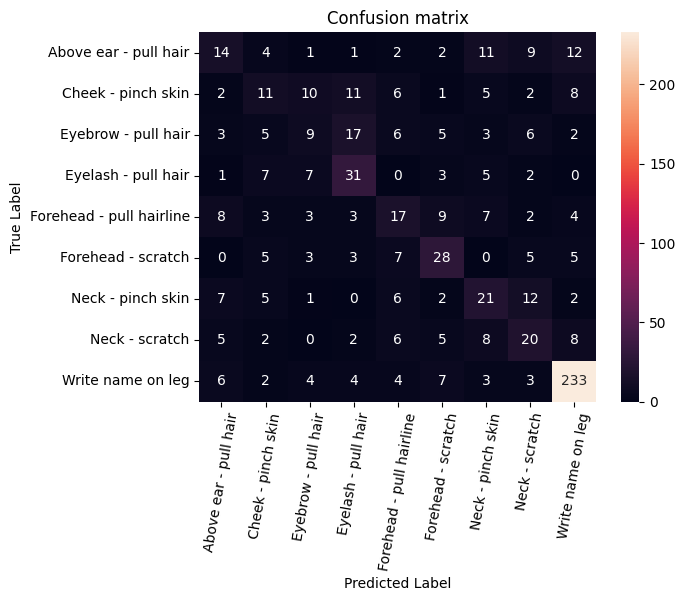

In [60]:
# fold = get_avg_fold(folds_score)
fold = folds_score[2]

macro = fold["f1_macro"]
binary = fold["f1_binary"]
competition_eval = fold["competition_evaluation"]
cm = fold['confusion_matrix']

print(f'macro: {macro:.2f}, binary: {binary:.2f}, competition: {competition_eval:.2f}')

plot_cm(cm, list(encoder.classes_))
fold["classification_report"]

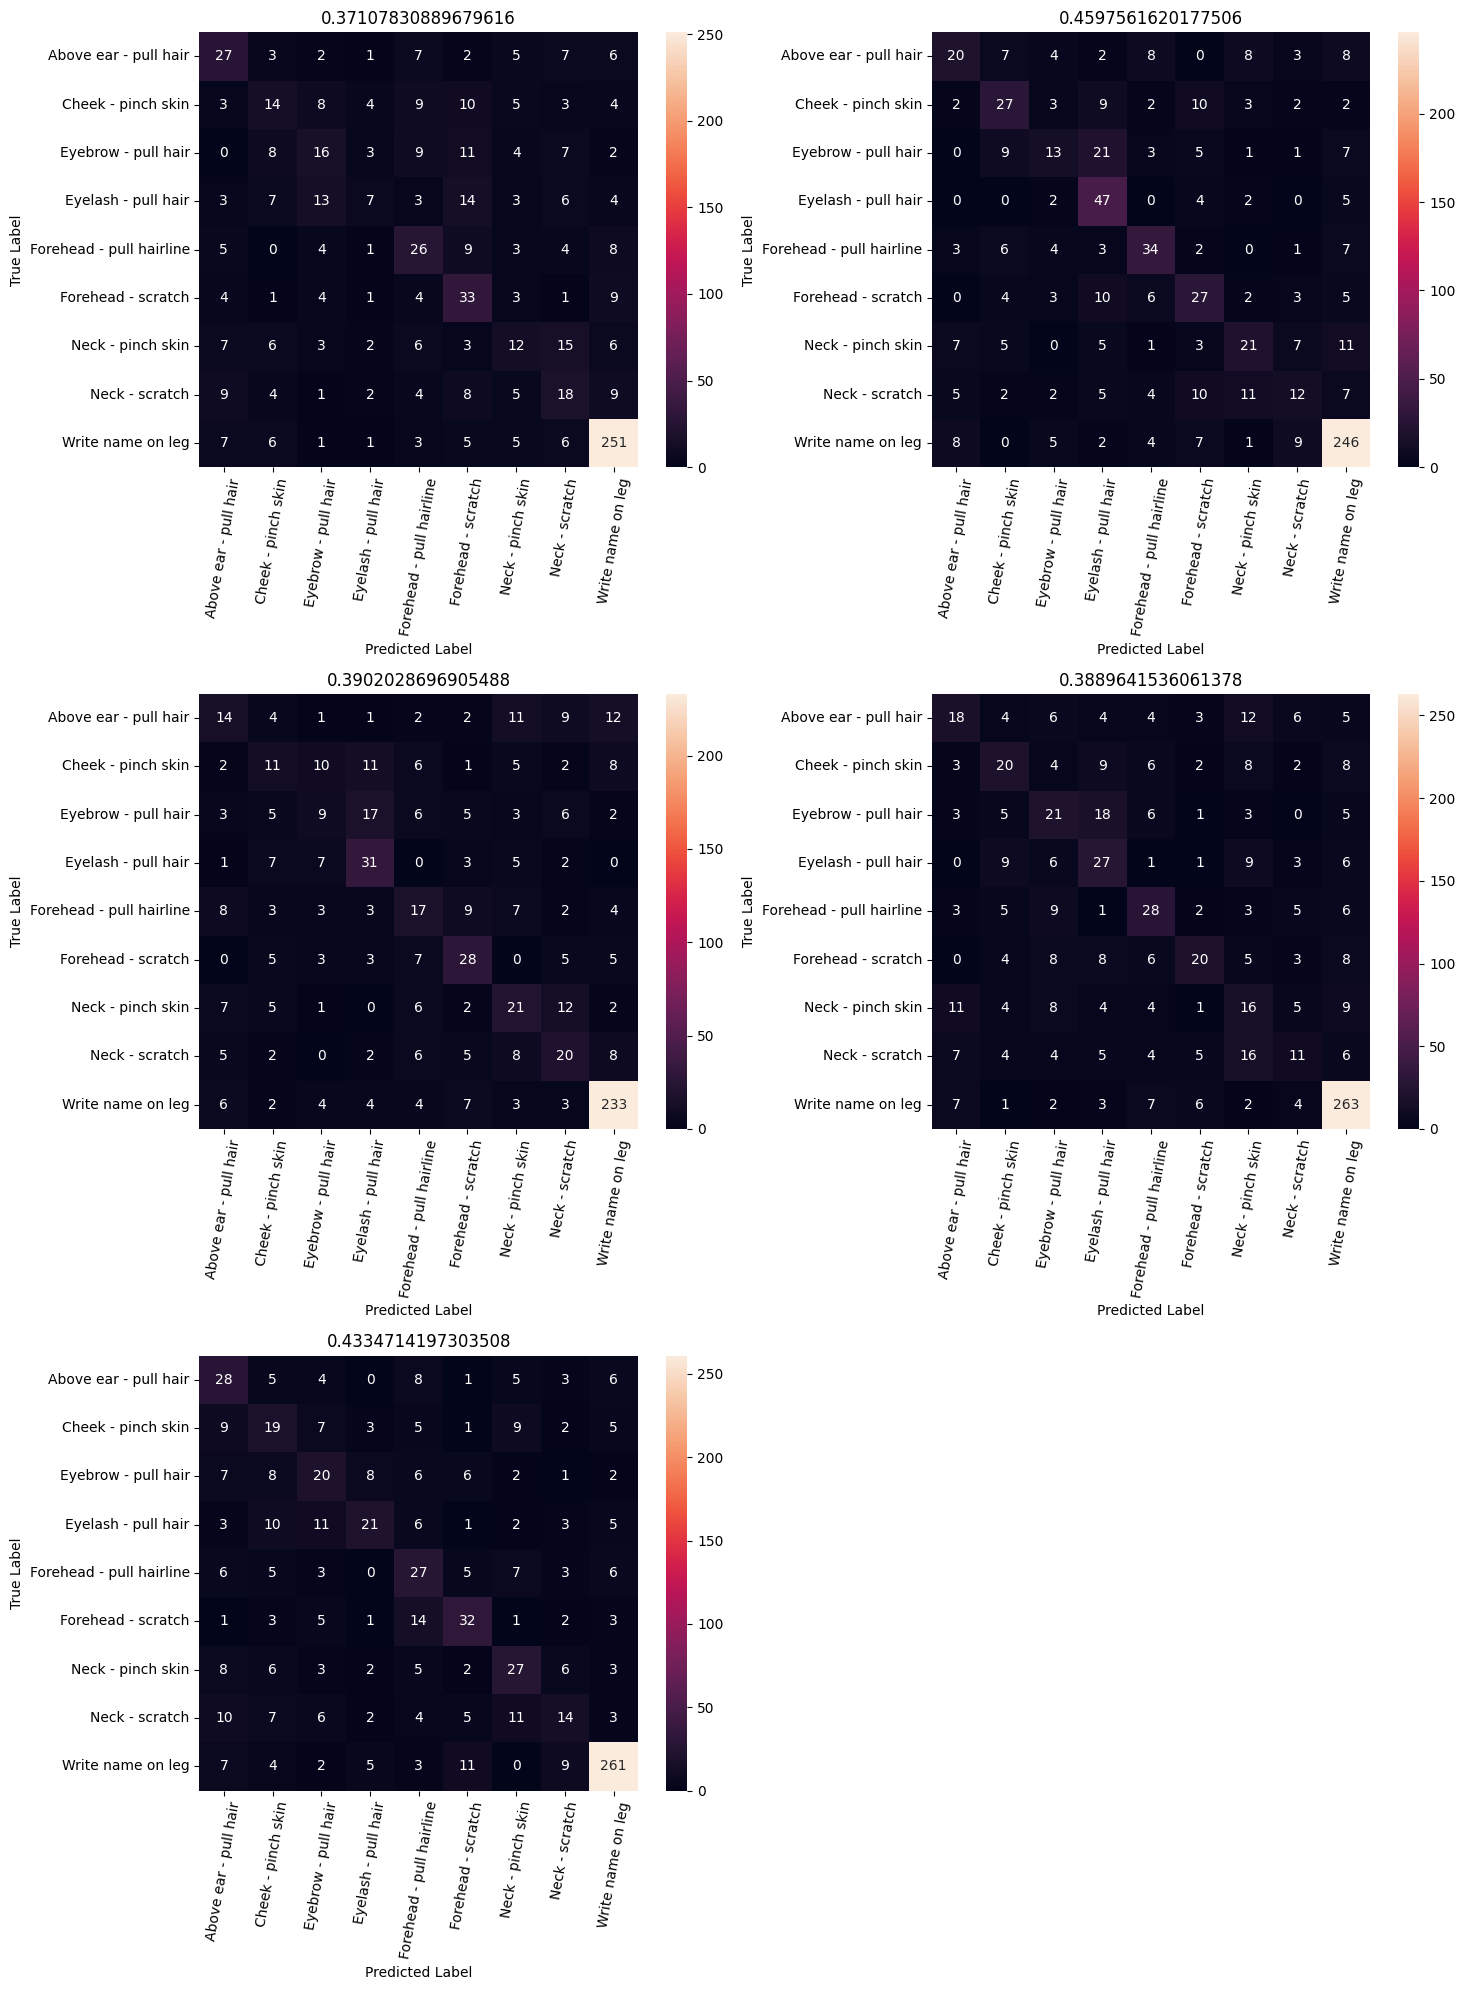

In [81]:
plt.figure(figsize=(15, 20))
for i, fold in enumerate(folds_score, start=1):
    plt.subplot(3, 2, i)
    plot_cm(fold["confusion_matrix"], list(encoder.classes_))
    plt.title(fold['f1_macro'])

plt.tight_layout()
# plt.subplots_adjust(hspace=0.8)

good subjects: ['SUBJ_040733' 'SUBJ_055211' 'SUBJ_059330' 'SUBJ_038023' 'SUBJ_044680'
 'SUBJ_021670' 'SUBJ_008304' 'SUBJ_036450']
bad subjects: ['SUBJ_001430' 'SUBJ_024137' 'SUBJ_061552' 'SUBJ_040106' 'SUBJ_034631'
 'SUBJ_008728' 'SUBJ_042254']


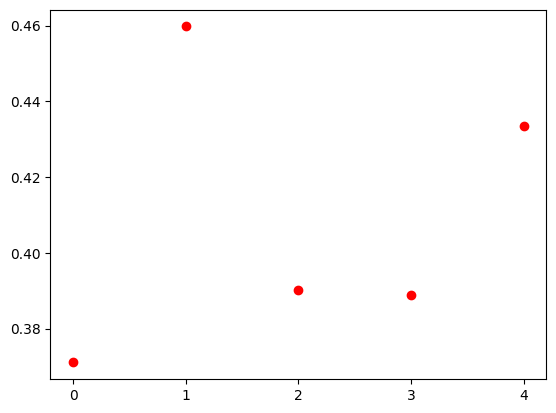

In [55]:
macros = [f["f1_macro"] for f in folds_score]
plt.plot(np.arange(len(macros)), macros, 'ro')
plt.xticks(np.arange(len(macros)))

bad_idx = 2
good_idx = 4

print(f'good subjects: {test_subjects[good_idx]}')
print(f'bad subjects: {test_subjects[bad_idx]}')

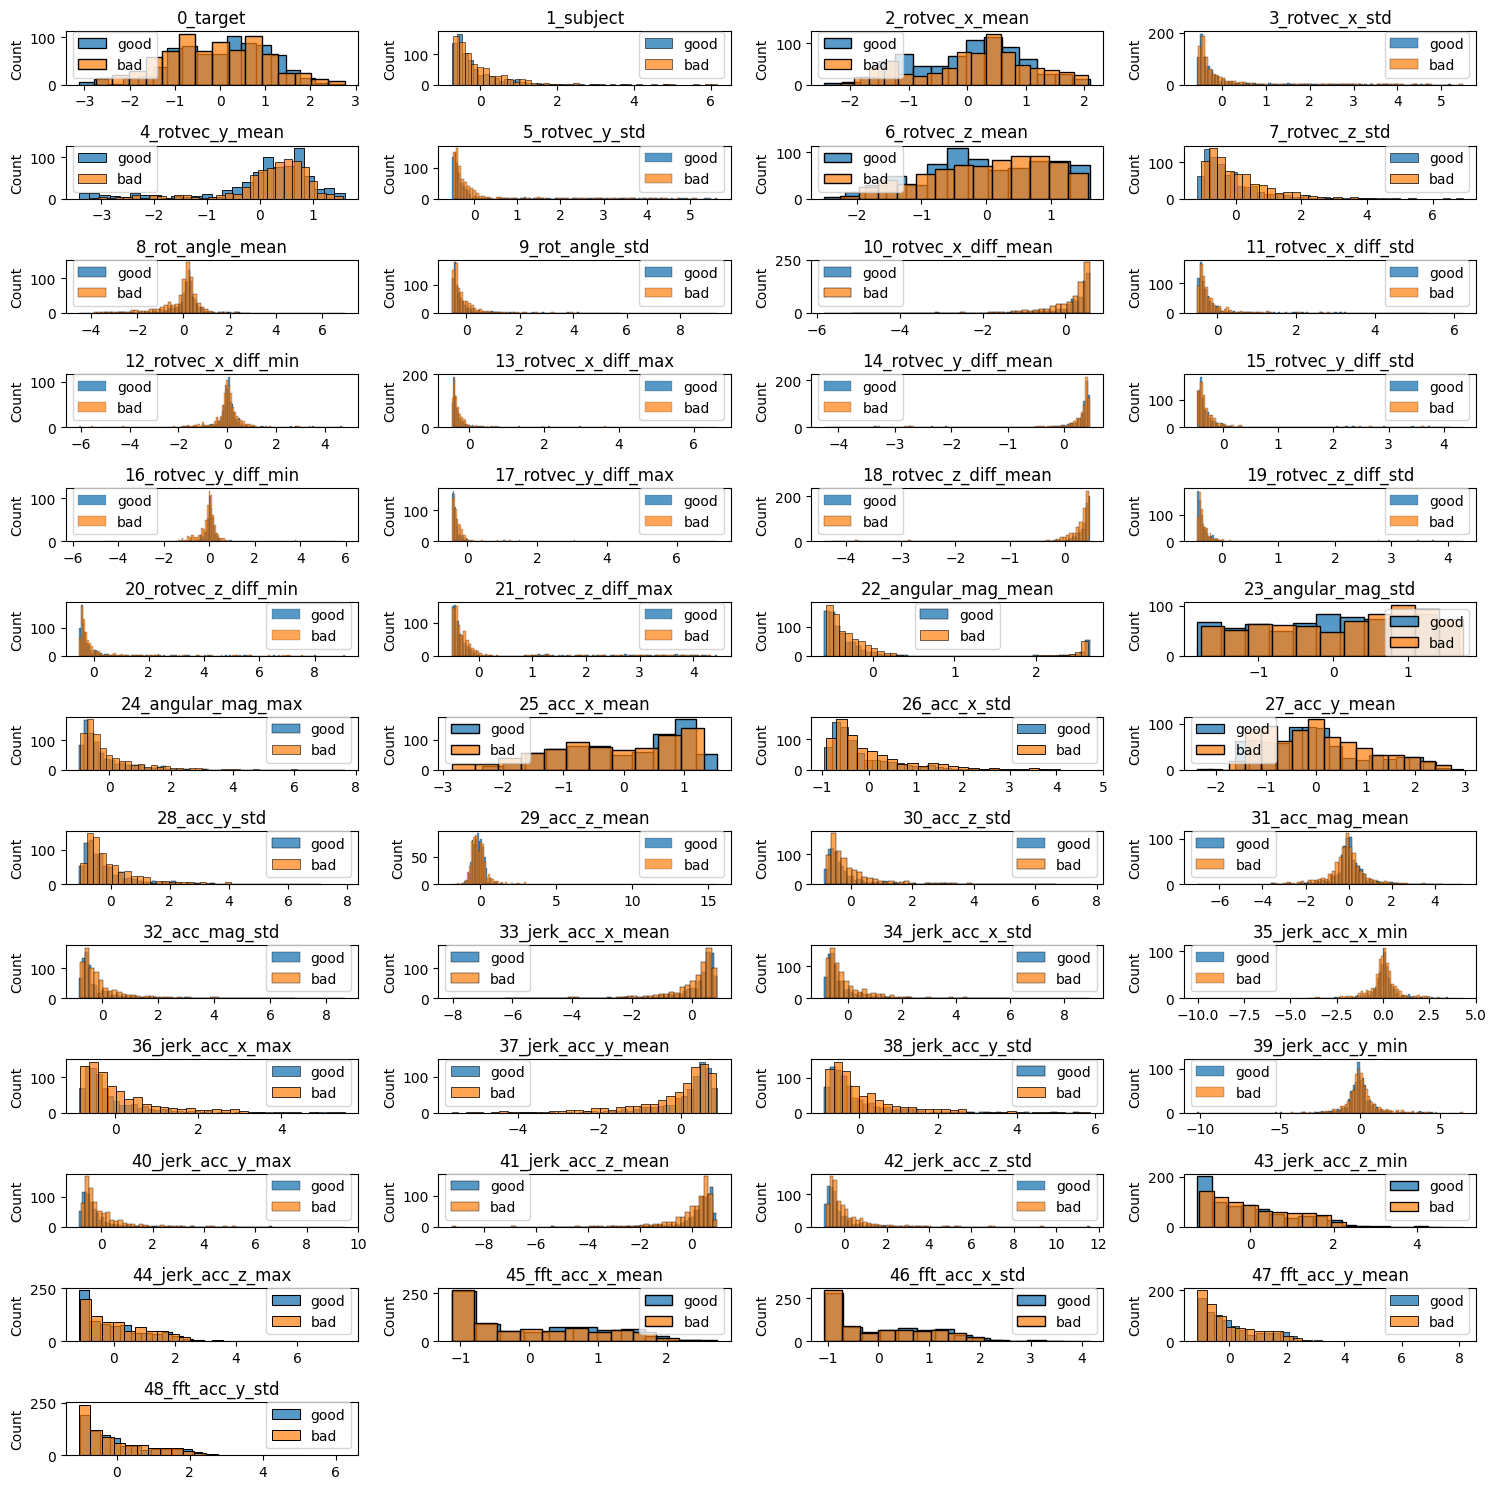

In [50]:
# sub_df = pd.DataFrame(
#     {
#         "value": np.concat([data_good, data_bad]),
#         "fold": ["good"] * len(data_good) + ["bad"] * len(data_bad),
#     }
# )


graph_idx = 1
plt.figure(figsize=(15, 15))
for feature_idx in range(0, X_train_arr[0].shape[1]):
    data_good = X_test_arr[good_idx][:, feature_idx]
    data_bad = X_test_arr[bad_idx][:, feature_idx]

    plt.subplot(13, 4, graph_idx)
    plt.title(f"{feature_idx}_{filtered_df.columns[feature_idx]}")
    sns.histplot(data_good, label="good")
    sns.histplot(data_bad, alpha=0.7, label="bad")
    plt.legend()

    graph_idx += 1

plt.tight_layout()

<Axes: ylabel='Count'>

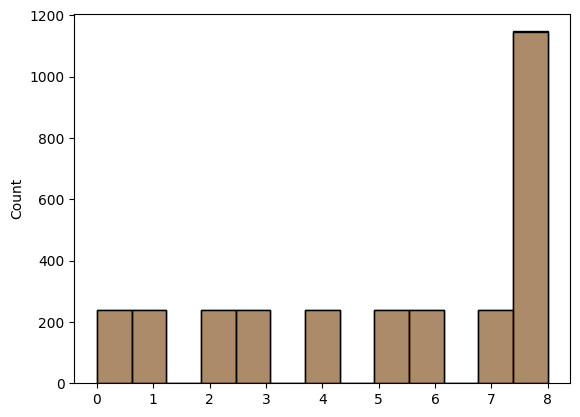

In [53]:
sns.histplot(y_train_arr[good_idx])
sns.histplot(y_train_arr[bad_idx], alpha=0.5)

In [ ]:
# final train model
n_epochs = 400
model = SimpleModel(len(encoder.classes_))

dataset_all = TensorDataset(features_tensor, target_tensor)
dataloader_all = DataLoader(dataset_all, batch_size=batch_size, shuffle=True)

train_model(model, dataloader_all, n_epochs, should_log=True)
torch.save(model.state_dict, '../models/model.pth')

0 - loss_avg: 1.7670864285901189
20 - loss_avg: 1.3435163935646415
40 - loss_avg: 1.2941331644542515
60 - loss_avg: 1.2580602089874446
80 - loss_avg: 1.2367916163057089
100 - loss_avg: 1.2189869447611272
120 - loss_avg: 1.2041548932902515
140 - loss_avg: 1.1891458523459733
160 - loss_avg: 1.1784265250898898
180 - loss_avg: 1.1631644000299275
200 - loss_avg: 1.1489455755800009
220 - loss_avg: 1.1393039487302303
240 - loss_avg: 1.130943219177425
260 - loss_avg: 1.1241767010651529
280 - loss_avg: 1.1117427400313318
300 - loss_avg: 1.1023416174575686
320 - loss_avg: 1.0911986152641475
340 - loss_avg: 1.0916559724137187
360 - loss_avg: 1.0821397854015231
380 - loss_avg: 1.0796014992520213
